<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/Dog-breed-tulam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2900","key":"977eb592f0fe57a4c97e7d050cf9c637"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list

-rw-r--r-- 1 root root 64 Apr  7 02:17 kaggle.json
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          19914  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          24652  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           3850  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          18433  
fivethi

In [97]:
!kaggle competitions download -c dog-breed-identification
!unzip labels.csv.zip
!unzip train.zip
!unzip test.zip
!unzip sample_submission.csv.zip

labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  labels.csv.zip
replace labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train.zip
replace train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.zip
replace test/000621fb3cbb32d8935728e48679680e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/000621fb3cbb32d8935728e48679680e.jpg  
  inflating: test/00102ee9d8eb90812350685311fe5890.jpg  
  inflating: test/0012a730dfa437f5f3613fb75efcd4ce.jpg  
  inflating: test/001510bc8570bbeee98c8d80c8a95ec1.jpg  
  inflating: test/001a5f3114548acdefa3d4da05474c2e.jpg  
  inflating: tes

# 1. Import Thư Viện

In [131]:
import os
import csv
import tempfile
from os import listdir
from io import StringIO
from pathlib import Path
from itertools import islice
from os.path import join, abspath
from collections import namedtuple

import cv2
import pickle
import h5py
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss
from sklearn.externals import joblib
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

labels = pd.read_csv('labels.csv')
df_train = os.path.join('train')
df_test = os.path.join('test')
sample = pd.read_csv('sample_submission.csv')
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# 2. Load File và Đọc File

In [0]:
def load_file(fileNames):
  return [join(fileNames,fileName) for fileName in listdir(fileNames)]

In [0]:
train_path = load_file(df_train)
test_path = load_file(df_test)

In [0]:
train_path

In [0]:
train_path = sorted(train_path)
test_path = sorted(test_path)

In [8]:
print(len(train_path),len(test_path))

10222 10357


# 3. Chuyển Hình Ảnh thành Ma trận

In [0]:
def rescale(img):
  return cv2.resize(img,(100,100),interpolation = cv2.INTER_AREA)
X_train = [rescale(plt.imread(train_path)) for train_path in train_path]
X_test = [rescale(plt.imread(test_path)) for test_path in test_path]


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

# Lưu Vào Thành File Và Mở File

In [0]:
def save_data(file, fileName):
  with open(fileName, 'wb') as f:
    pickle.dump(file,f)
  f.close()
def open_data(file):
  with open(file,'rb') as f:
    file = pickle.load(f)
  return file
    

In [0]:
# lưu file data
save_data(X_train,"trainDf")
save_data(X_test,"testDf")

In [0]:
# thông tin data thành ma trận
file_train = open_data("trainDf")
file_test = open_data("testDf")

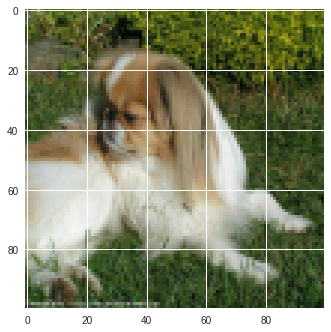

In [14]:
# show bức ảnh đầu tiên
plt.imshow(file_train[0])
plt.imshow(file_test[0])

# 4. Xử lý Label Chuyển Từ String thành Binary

In [0]:
labels = pd.read_csv('labels.csv')
def process_labels(data):
  breed = data['breed']
  files = []
  for file in breed:
    if file not in files:
      files.append(file)
  _labels = [[index, label] for index, label in enumerate(files)]      

In [0]:

breed = labels['breed']
files = []
for file in breed:
  if file not in files:
    files.append(file)


In [0]:
files.sort()


In [18]:
_labels = [[label, index] for index, label in enumerate(files)]
print(len(breed), len(_labels))

10222 120


In [19]:
_labels[0]

['affenpinscher', 0]

In [0]:
for i in range(len(breed)):
  for j in _labels:
    if breed[i] == j[0]:
      breed[i] = j[1]
      break

In [0]:
def _categorical(data):
  _labels = [label for label in data['breed']]
  count = 0
  _labelsAndCount = []
  for item in _labels:
    _labelsAndCount.append([i,count])
    count = count+1
  return count, _labelsAndCount
# _categorical keras chi so sanh gia tri label voi index 
# vi du son >>> so


In [0]:
from keras.utils import to_categorical
breed = to_categorical(breed)

In [23]:
breed.shape

(10222, 120)

In [24]:
y = np.array(breed)
y.shape

(10222, 120)

In [25]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [0]:
# su dung labelencoder va onehotencode su ly data
labels = pd.read_csv('labels.csv')
breed = labels['breed']

def procesdata_in_sklearn(data):
  enc = LabelEncoder()
  numbers = enc.fit_transform(data)
  df = pd.DataFrame(numbers,data)
  enc1 = OneHotEncoder(categories='auto')
  y = enc1.fit_transform(df).toarray()
  return y

In [0]:
y_pred = procesdata_in_sklearn(breed)


In [28]:
y_pred.shape

(10222, 120)

# 6. Xử Lý Ảnh 

In [0]:
def shuffleImage(data):
  index = np.array(list(range(file_train.shape[0])))
  np.random.shuffle(index)
  return index[:10]

In [55]:
rand_image = shuffleImage(file_train)
print(rand_image)
Xs = file_train[rand_image]
print("cac phan tu cua Xs:" ,shuffleImage(file_train))
Ys = y[rand_image]
print("cac phan tu cua Ys:", shuffleImage(file_train))

[10041  8676  9045  5109  3691  1533  9363  9878  2370  4261]
cac phan tu cua Xs: [10146  2747  5805  4770  6642 10186   635  2584  7954   674]
cac phan tu cua Ys: [8114 5014 8153 7366  919 8235 5246  688 2445 9444]


In [31]:
Xs = (Xs-127.5)/255
print(Xs.dtype)
print(Xs.mean())
print(Xs.max())
print(Xs.min())
print(Xs.nbytes/10**9)

float64
-0.08701813071895424
0.5
-0.5
0.0024


In [32]:
Xs = Xs.astype('float32')
print(Xs.dtype)
print(Xs.nbytes/10**9)

float32
0.0012


In [62]:
type(Xs[2])

numpy.ndarray

# Visualizing training data distribution

**1. let’s do the data visualization for better understanding the data**

In [132]:
breed_counts = pd.pivot_table(labels, index=['breed'], aggfunc='count')
# rename the column
breed_counts = breed_counts.rename(columns = {"id" : "count"})
# show in desending order 
breed_counts = breed_counts.sort_values("count", ascending=False)
# show top 5 rows
breed_counts.head(5)


,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Distribution of Dog breeds')

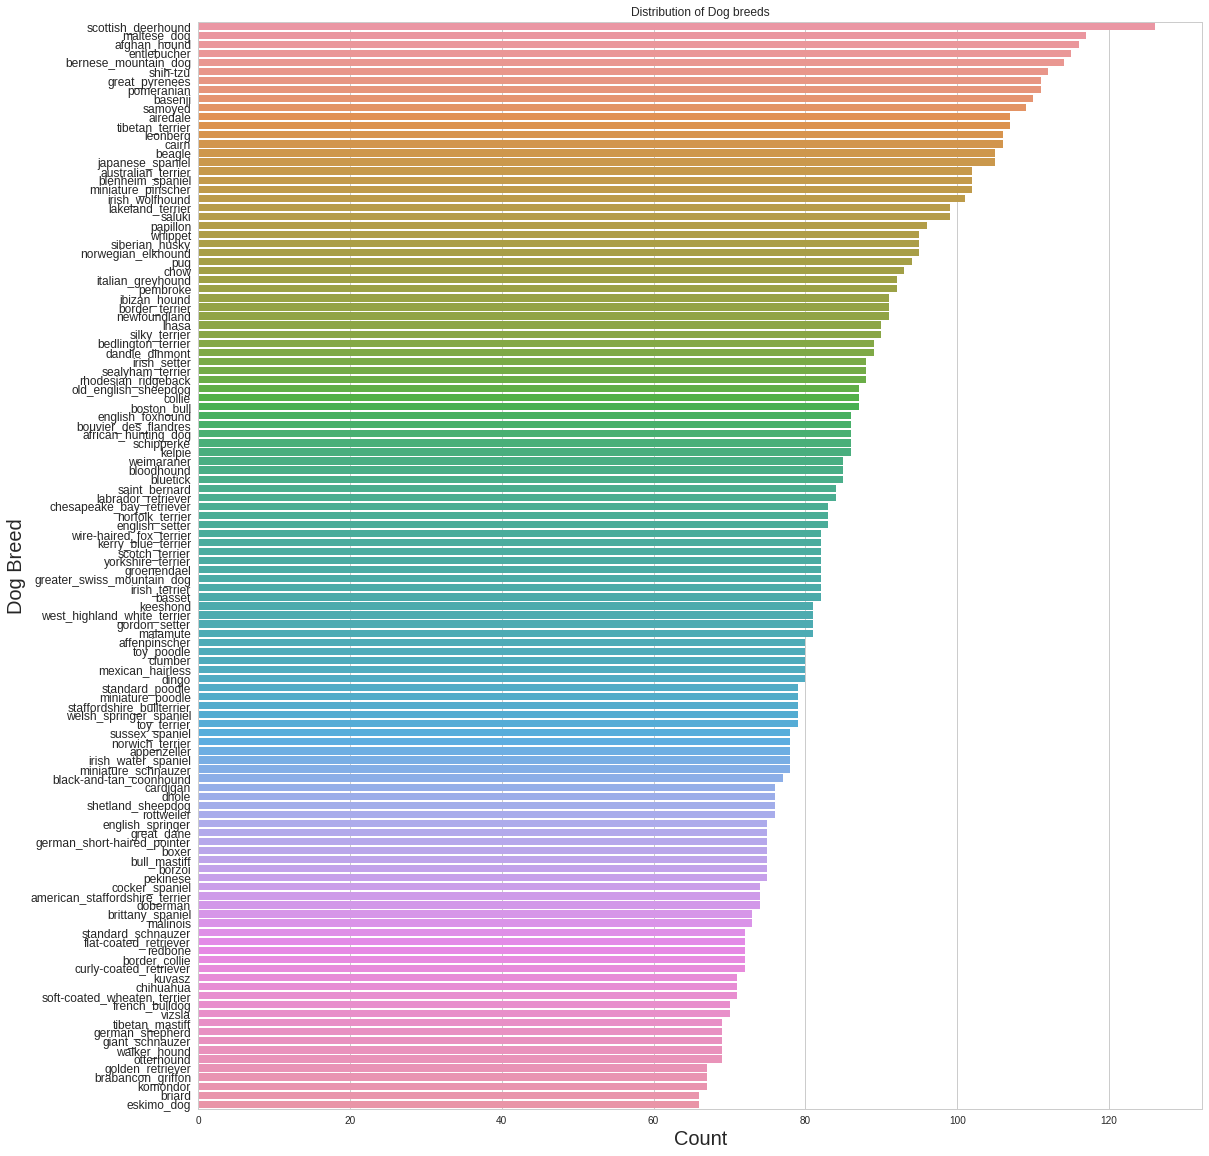

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(18,20)
sns.set_style("whitegrid")

ax = sns.barplot(x = breed_counts['count'], y = breed_counts.index, data = labels)
# vẽ ra biểu đồ cột các giá trị của breed_count
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
# xác định khoảng cách của x và y
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.set(xlabel='Count',ylabel='Dog Breed')
ax.set_title('Distribution of Dog breeds')

**2.loading the corresponding Images**

#  Xây Dựng Model

In [0]:
import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

In [0]:
def Builde_model():
  """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
  model = Sequential()
  # x(shortcut)
  # X(Shortcut) 
  # xay dung model convolution với 32 dense
  model.add(Conv2D( 32, 3, input_shape=(100,100,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(32,  3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  # xay dung model convolution voi 16
  model.add(Conv2D(16,3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(16,3))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  # xay dung model voi 256 dense
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(120))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(120))
  model.add(Activation('softmax'))
  
  model.compile(optimizer = Adam(lr = 0.001),
                loss = 'mse',
                metrics=['mse','accuracy']
               )
  return model


In [0]:
model = Builde_model()
t0=time.time()
log3 = model.fit(Xs, Ys, validation_split=0.2, epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

#scores3 = model.evaluate(X_test, y_test, verbose=0)
#print("CNN Error: %.2f%%" % (100-scores3[1]*100))
 
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

In [0]:
def build_1():
  model = Sequential()
  model.add(x)